# EDA for Raw Data

### Contains two components.
    1. Exploratory Data Pre-processing
    2. Exploratory Data Analysis

In [141]:
import json
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path
from collections import Counter

In [142]:
print(os.getcwd())

D:\Desktop\FY\FYP\researchproject


#### Change working directory to project directory

In [143]:
os.chdir(r'D:\Desktop\FY\FYP\researchproject')

In [144]:
from src.utils import get_unique_id, load_config

### Paths

In [145]:
config = load_config('config.yaml')
OUTPUT_PATH = Path(config['EXPLORATORY_DATA_PATH'])
MERGED_DATA_PATH = Path(config['MERGED_DATA_PATH'])
NER_CORPUS_PATH = Path(config['NER_CORPUS_PATH'])
STOP_WORDS_CORPUS_PATH = Path(config['STOP_WORDS_CORPUS_PATH'])
NOTOSANS_FONT_PATH = Path(config['NOTOSANS_FONT_PATH'])

In [146]:

df = pd.read_json(MERGED_DATA_PATH)

In [147]:
df.shape

(57143, 6)

In [148]:
df.head(5)

,category,site,url,title,context,id
0,Sports_news,ada,https://www.ada.lk/international/සමූල-ඝාතකයාට-...,"සමූල ඝාතකයාට වසර 2,208ක සිර දඬුවමක්",www.ada.lk\n2024 ඔක්තෝබර් මස 16 වන බදාදා\n2024...,00066ea29327429fb4bfb7d2
1,Local-news,ada,https://www.ada.lk/breaking_news/ඉම්රාන්-ඛාන්-...,ඉම්රාන් ඛාන් අත්අඩංගුවට,www.ada.lk\n2024 සැප්තැම්බර් මස 24 වන අඟහරුවාද...,0006bb0ecbe94def8fabf6a2
2,Local-news,ada,https://www.ada.lk/breaking_news/සැකකටයුතු-මරණ...,සැකකටයුතු මරණ දෙකක්,www.ada.lk\n2024 සැප්තැම්බර් මස 24 වන අඟහරුවාද...,000b619063ea41e3a98ee672
3,Local-news,ada,https://www.ada.lk/breaking_news/මැතිවරණය-රට-ස...,මැතිවරණය රට ස්ථාවර වූ පසුවයි,www.ada.lk\n2024 සැප්තැම්බර් මස 24 වන අඟහරුවාද...,000dd069dc5643039bec9924
4,Local-news,ada,https://www.ada.lk/breaking_news/පුනාගල-නාය-යෑ...,පුනාගල නාය යෑමක්,www.ada.lk\n2024 සැප්තැම්බර් මස 24 වන අඟහරුවාද...,0015e3f5b2f64c848ff7851b


In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57143 entries, 0 to 57142
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  57143 non-null  object
 1   site      57143 non-null  object
 2   url       57143 non-null  object
 3   title     57143 non-null  object
 4   context   57143 non-null  object
 5   id        57143 non-null  object
dtypes: object(6)
memory usage: 2.6+ MB


# Exploratory Data cleaning 


1. Check for mismatches in category type names and correct them 
2. Drop the entries with English characters
4. Drop entries with special chcarcters
5. Drop entries with Mathematical equations and related symbols
6. Remove white spaces
7. Replace \n with a space ---- ada/lankadeepa/hiru
8. Check each site and see what to clean
    1. Wiki --- Drop articles wityh less than 5 passsages scraped
    2. hiru --- leading and trailing whitespaces
    3. adaderena - take all lines to one paragraph
    4. lankadeepa --- remove before first \n --- take all lines to one paragraph
    5. divaina --- all good
9. Remove duplicates  from context 
10. Remove duplicated titles excluding wiki 
11. Drop rows with context word count not between 200 and 4000 words

### Make a copy of the original DataFrame to use for cleaning

In [150]:

df_cleaned = df.copy()

### Check for mismatches in category type names and correct them 

In [151]:
print("Categories in 'category' variable: " )
print(df_cleaned['category'].unique())

Categories in 'category' variable: 
['Sports_news' 'Local-news' 'International_news' 'Business_news'
 'International-news' 'business/all news' 'local news'
 'international news' 'sports/all news' 'entertainment/all news'
 'All news' 'Wiki']


In [152]:
df_cleaned['category'] = df_cleaned['category'].replace({
    'local news': 'Local-news',
    'International_news': 'International-news',
    'international news': 'International-news',
    'business/all news': 'Business-news',
    'Business_news': 'Business-news',
    'sports/all news': 'Sports-news',
    'Sports_news': 'Sports-news',
    'entertainment/all news': 'Entertainment-news',
    'All news': 'All-news'
})

In [153]:

print("Categories in 'category' variable after cleaning: " )
print(df_cleaned['category'].unique())

Categories in 'category' variable after cleaning: 
['Sports-news' 'Local-news' 'International-news' 'Business-news'
 'Entertainment-news' 'All-news' 'Wiki']


### Site vise cleaning context

In [154]:
print("Categories in 'site' variable : " )
print(df_cleaned['site'].unique())

Categories in 'site' variable : 
['ada' 'adaderena' 'divaina' 'hiru_news' 'lankadeepa' 'si.wikipedia.org']


### Check for special characters and English characters

In [155]:
# Define regular expressions 
special_char_pattern = re.compile(r'[^\w\s]', re.UNICODE)  # special characters excluding word characters and spaces
english_letters_pattern = re.compile(r'[A-Za-z]')  # matches English letters

# Define counters for occurrences
df_cleaned['special_char_count'] = df_cleaned['context'].apply(lambda x: len(re.findall(special_char_pattern, x)))
df_cleaned['english_letter_count'] = df_cleaned['context'].apply(lambda x: len(re.findall(english_letters_pattern, x)))

# Summarize total counts for each category across entries
summary = {
    "Total Entries": len(df_cleaned),
    "Entries with Special Characters": (df_cleaned['special_char_count'] > 0).sum(),
    "Entries with English Letters": (df_cleaned['english_letter_count'] > 0).sum()
}

# Calculate percentage of entries containing each category
summary_percentage = {key: f"{(value / len(df) * 100):.2f}%" for key, value in summary.items() if key != "Total Entries"}

summary, summary_percentage

({'Total Entries': 57143,
  'Entries with Special Characters': 52076,
  'Entries with English Letters': 20786},
 {'Entries with Special Characters': '91.13%',
  'Entries with English Letters': '36.38%'})

### Drop the entries with English characters

In [156]:
# Filter out rows where 'english_letter_count' is greater than 0
df_cleaned_no_english = df_cleaned[df_cleaned['english_letter_count'] == 0]

# Verify the result by printing the shape of the cleaned DataFrame
print(f"Original DataFrame shape: {df_cleaned.shape}")
print(f"DataFrame shape after removing rows with English characters: {df_cleaned_no_english.shape}")

Original DataFrame shape: (57143, 8)
DataFrame shape after removing rows with English characters: (36357, 8)


### Drop entries with special chcarcters

In [157]:
# Function to check if a row contains any special characters to drop
def drop_rows_with_special_chars(df, column_name='context'):
    # Define the special characters to check for
    special_chars = ['[', ']', '{', '}', '"', "'", '/', '\\']

    # Filter rows where the context column contains any of the special characters
    mask = df[column_name].apply(lambda x: any(char in x for char in special_chars))

    # Drop rows that contain any of the special characters
    df_cleaned = df[~mask]  # ~mask means we keep rows where mask is False (i.e., no special characters)

    return df_cleaned

cleaned_df = drop_rows_with_special_chars(df_cleaned_no_english)

# Verify the result by printing the shape or preview of the cleaned DataFrame
print(f"Original DataFrame shape: {df_cleaned_no_english.shape}")
print(f"Cleaned DataFrame shape: {cleaned_df.shape}")

Original DataFrame shape: (36357, 8)
Cleaned DataFrame shape: (30945, 8)


### Drop entries with Mathematical equations and related symbols

In [158]:
# Update the regex pattern to detect sequences that resemble mathematical equations (numbers/operators)
math_pattern = r'\d\s*[\+\-\*/^=]\s*\d'

# Apply the updated pattern to detect rows with mathematical-like sequences
math_rows = cleaned_df['context'].str.contains(math_pattern)

# Count rows with detected equations
math_equations_count = math_rows.sum()
print(f"Number of rows with mathematical-like sequences: {math_equations_count}")

cleaned_df = cleaned_df[~math_rows].reset_index(drop=True)

Number of rows with mathematical-like sequences: 722


In [159]:
cleaned_df.shape

(30223, 8)

### Hiru news

In [160]:
hiru_contexts = cleaned_df.loc[cleaned_df['site'] == 'hiru_news', 'context']

# Print the contexts
print("Context from rows with site name 'hiru':")
print(hiru_contexts.iloc[0])

Context from rows with site name 'hiru':

                        රන් පවුමක මිල සීග්‍ර ලෙස ඉහල යාම හේතුවෙන් ලක්ෂ 5ක් පමණ වන තම කර්මාන්තකරුවන් අපහසුතාවයට පත්ව ඇති බව සමස්ත ලංකා රන් කරුවන්ගේ සංගමය පවසනවා. නිට්ටඹුවේ අද පැවති මාධ්‍ය හමුවකට එක්වෙමින් එහි සභාපති මංගල හර්ෂ කුමාර මේ බව සඳහන් කළා.                        
          
        


#### No issues in Hiru news content

### ADA news

#### ada was removed due to having too many noise data

In [161]:
# ada_contexts = cleaned_df.loc[cleaned_df['site'] == 'ada', 'context']

# # Print the contexts
# print("Context from rows with site name 'ada':")
# print(ada_contexts.iloc[0])

#### ADA news site has unwanted content in the start and at the end which is not part of the passage. Needs to remove them and bring the lines to one paragraph.

In [162]:
# def remove_first_and_last_lines(text, num_first=3):
#     lines = text.split('\n')
#     if len(lines) > num_first:
#         modified_text = '\n'.join(lines[num_first:])
#         # Find the index of the word "popular" 
#         popular_index = modified_text.find("popular")
#         if popular_index != -1:
#             # Remove everything from "popular" onwards
#             return modified_text[:popular_index].rstrip() 
        
#         return modified_text.rstrip()  # If "popular" is not found, return the modified passage
#     else:
#         # If not enough lines, return an empty string
#         return ''


# cleaned_df.loc[cleaned_df['site'] == 'ada', 'context'] = cleaned_df.loc[cleaned_df['site'] == 'ada', 'context'].apply(remove_first_and_last_lines)

### Ada Derena news

In [163]:
adaderena_contexts = cleaned_df.loc[cleaned_df['site'] == 'adaderena', 'context']

# Print the contexts
print("Context from rows with site name 'adaderena':")
print(adaderena_contexts.iloc[0])

Context from rows with site name 'adaderena':
ඇසේ සුද ඉවත් කිරීමේ සැත්කමක් සිදු කිරීමෙන් පසුව රෝහලින් ලබා දුන් ඖෂධ භාවිත කිරීම හේතුවෙන් ඇස් පෙනීම අහිමි වූ බව පවසමින් වන්දි ඉල්ලා පුරවැසියන් තිදෙනෙකු විසින් කොළඹ දිසා අධිකරණය හමුවේ නඩු ගොනුකර තිබේ.
කඳපොළ ප්‍රදේශයේ පදිංචි එම්. රාජරත්නම් ඇතුළු තිදෙනෙකු විසින් මෙම පැමිණිලි ඉදිරිපත් කර ඇත.
පැමිණිකරුවන් ඉල්ලා ඇත්තේ තමන්ට සිදුවූ හනිය වෙනුවෙන් එවක සෞඛ්‍ය අමාත්‍ය කෙහෙළිය රඹුක්වැල්ල මහතා ඇතුළු වගඋත්තරකරුවන් ගෙන් රුපියල් කෝටි 10 බැගින් වන්දි ලබාදෙන ලෙසට නියෝගයක් නිකුත් කරන ලෙසටය.
එහි වගඋත්තරකරුවන් ලෙස හිටපු සෞඛ්‍ය අමාත්‍ය කෙහෙළිය රඹුක්වැල්ල, එම අමාත්‍යංශයේ හිටපු ලේකම් ජනක චන්ද්‍රගුප්ත, ජාතික ඖෂධ නියාමන අධිකාරිය, සෞඛ්‍ය සේවා අධ්‍යක්ෂ ජනරාල් අසේල ගුණවර්ධන ඇතුළු 11 දෙනෙකු නම් කර තිබේ.


#### Ada Derena news has passage in different lines need to bring them together to one paragraph.

### Lankadeepa news

In [164]:
lankadeepa_contexts = cleaned_df.loc[cleaned_df['site'] == 'lankadeepa', 'context']

# Print the contexts
print("Context from rows with site name 'lankadeepa':")
print(lankadeepa_contexts.iloc[0])

Context from rows with site name 'lankadeepa':
(ජේ.ඉඳුරුවගේ)
දැනට වසර 109 කට පෙර මෙරට බ්‍රිතාන්‍ය පාලකයන් විසින් අසාධාරණ ලෙස මරණයට පත් කරනු ලැබූ කපිතාන් දියුණුගේ එඩ්වර්ඩ් හෙන්රි පේද්‍රිස් මහතාට වසර 110කට පමණ පසු ජනාධිපති සමාව ලබා දෙයි.
ආණ්ඩුක්‍රම ව්‍යවස්ථාවේ 33(ඌ)ව්‍යවස්ථාව ප්‍රකාරව පැවරී ඇති බලතල අනුව ජනාධිපති රනිල් වික්‍රමසිංහ මහතා විසින් මෙම ජනාධිපති සමාව ප්‍රකාශයට පත් කළ අති විශේෂ ගැසට් නිවේදනය ඊයේ(12)නිකුත් කෙරිණි .
එවකට ලංකාවේ ආන්ඩුකාරවරයා වූ රොබර්ට් චාමර්ස් විසින් 1915 ජුනි 25 දින නිකුත් කළ ප්‍රකාශයක් මගින් පත් කරනු ලැබූ යුධ අධිකරණයකින් සිදුකළ අසාධාරණ නඩු විභාගයකින් පසු 1915 ජූලි 07 දින නීති විරෝධී ලෙස මරණයට පත් කළේය. දියුණුගේ එඩ්වර්ඩ් හෙන්රි පේද්‍රිස් මහතාට මරණින් පසු ජනාධිපති පිරිනමන බව මෙම ගැසට් නිවේදනයෙන් ප්‍රකාශයට පත්කර තිබේ.
1888 අගෝස්තු 16 දින ගාල්ලේදී උපත ලැබූ හෙන්රි පේද්‍රිස් මහතා බ්‍රිතාන්‍ය පාලන සමයේ ලංකාවේ විසූ ප්‍රමුඛ පෙළේ සමාජ ක්‍රියාකාරිකයකු මෙන්ම ලංකා ආරක්ෂක හමුදාවේ සහ කොළඹ නගරාරක්ෂක බළකායේ සේවය කළ කපිතාන් නිලයක් හෙබවූ හමුදා නිලධාරියකුද විය.
බ්‍රිතාන්‍ය නිලධාරීන්

#### Lankadeepa news has unwanted content at the start  --- author name. And has content in different lines need to bring to one paragraph.

In [165]:
# Function to remove the first line from the context --- author name
def remove_first_lines(text):
    lines = text.split('\n')
    # Keep everything after the first line
    return '\n'.join(lines[1:]) if len(lines) > 1 else ''

cleaned_df.loc[cleaned_df['site'] == 'lankadeepa', 'context'] = cleaned_df.loc[cleaned_df['site'] == 'lankadeepa', 'context'].apply(remove_first_lines)

### Divaina news

In [166]:
divaina_contexts = cleaned_df.loc[cleaned_df['site'] == 'divaina', 'context']

# Print the contexts
print("Context from rows with site name 'divaina':")
print(divaina_contexts.iloc[1])

Context from rows with site name 'divaina':
ජර්මනියේ සෝලින්ගන් නගරයේ 650 වැනි සංවත්සරය සැමරීම සඳහා ඉකුත් 24 වැනිදා පැවති උත්සවය අතරතුර සිදුවූ පිහිඇනුමේ වගකීම අයිඑස්අයිඑස් සංවිධානය විසින් භාරගෙන ඇත.


#### No issues in Divaina news content.

### Wiki data

In [167]:
wiki_contexts = cleaned_df.loc[cleaned_df['site'] == 'si.wikipedia.org', 'context']

# Print the contexts
print("Context from rows with site name 'wiki':")
print(wiki_contexts.iloc[1])

Context from rows with site name 'wiki':
තමන්ට වැළදෙන වසංගත රෝග වලින් ආරක්ෂා වීම පිණිස සතියකට වැඩි කළක් කරනු ලබන මෙම අං ඇදීම නොහොත් අංකෙලිය දවසේ සවස් වරුවේ සිදු කරනු ලැබේ. උඩු පිල සහ යටි පිළ යනුවෙන් දෙපිලකට බෙදී කරනු ලබන මෙම ක්‍රීඩාවේදී යටි පිළට ජය ලැබීම දේව නියමය වන බව විශ්වාස කරයි. යටි පිල ජයග්‍රහනය කිරීම ගමට හෝ ප්‍රදේශයට යහපත් බව පිළිගැනේ. අං කෙලිය ආරම්භ කිරීමට ප්‍රථම තම තම පිළේ කපුරාල විසින් මෙසේ කවි වලින් යාතිකාවක් කරනු ලැබේ.



### Drop wiki articles with less than 5 passages

In [168]:
# Step 1: Filter the DataFrame for the "si.wikipedia.org" site
wiki_df = cleaned_df[cleaned_df['site'] == 'si.wikipedia.org']

# Step 2: Count the occurrences of each title within the "si.wikipedia.org" site
title_counts_wiki = wiki_df['title'].value_counts()

# Step 3: Identify titles that occur less than 5 times
titles_to_drop_wiki = title_counts_wiki[title_counts_wiki < 5].index

print("Number of wiki titles that occur less than 5 times:", titles_to_drop_wiki.shape[0])

# Step 4: Drop rows from the original DataFrame where the site is "si.wikipedia.org" and the title occurs less than 5 times
cleaned_df = cleaned_df[~((cleaned_df['site'] == 'si.wikipedia.org') & (cleaned_df['title'].isin(titles_to_drop_wiki)))]

Number of wiki titles that occur less than 5 times: 2414


### Addressing the issues in Ada/ Lankadeepa/ Ada Derena/ wiki regarding having content in different line and bringing them to one paragraph.

In [169]:
# Function to remove '\n' by replacing it with a space across all string columns
cleaned_df = cleaned_df.apply(lambda x: x.str.replace('\n', ' ') if x.dtype == "object" else x)

### Remove Duplicates

In [170]:
# Step 1: Separate "wiki" and non-"wiki" rows
wiki_df = cleaned_df[cleaned_df['site'] == 'si.wikipedia.org']
non_wiki_df = cleaned_df[cleaned_df['site'] != 'si.wikipedia.org']

In [171]:
print(f"Number of duplicates in context column before cleaning: {cleaned_df.duplicated('context').sum()}")
print(f"Number of duplicates in title column before cleaning excluding wiki: {non_wiki_df.duplicated('title').sum()}")


Number of duplicates in context column before cleaning: 7587
Number of duplicates in title column before cleaning excluding wiki: 506


In [172]:
# Step 2: Drop duplicates in non-"wiki" rows based on 'title', keeping only the first occurrence
non_wiki_df = non_wiki_df.drop_duplicates(subset='title', keep='first')

# Step 3: Concatenate the "wiki" and deduplicated non-"wiki" data back together
cleaned_df = pd.concat([wiki_df, non_wiki_df])

# (Optional) Reset the index if needed
cleaned_df = cleaned_df.reset_index(drop=True)


In [173]:
cleaned_df = cleaned_df.drop_duplicates(subset='context', keep='first')
#cleaned_df = cleaned_df.drop_duplicates(subset='title', keep='first')

duplicate_count = cleaned_df.duplicated('context').sum()
print(f"Number of duplicates in context column after cleaning: {cleaned_df.duplicated('context').sum()}")
print(f"Number of duplicates in title column after cleaning: {cleaned_df.duplicated('title').sum()}")

Number of duplicates in context column after cleaning: 0
Number of duplicates in title column after cleaning: 3873


### Remove white spaces

In [174]:
# Check how many rows have empty or whitespace-only strings
print(f"\nNumber of rows with empty or whitespace-only strings in context column: {(cleaned_df['context'].str.strip() == '').sum()}")
print(f"\nNumber of rows with empty or whitespace-only strings in title column: {(cleaned_df['title'].str.strip() == '').sum()}")


Number of rows with empty or whitespace-only strings in context column: 2

Number of rows with empty or whitespace-only strings in title column: 0


In [175]:
cleaned_df = cleaned_df[cleaned_df['context'].str.strip() != '']
cleaned_df = cleaned_df[cleaned_df['title'].str.strip() != '']

### Add a new column to store the length of each 'context'

In [176]:

cleaned_df['context_length'] = cleaned_df['context'].str.len()

### Check for context lengths  --- mininmum/ Maximum/Average per site

In [177]:
site_length_stats = cleaned_df.groupby('site')['context_length'].agg(['min', 'max', 'mean'])
print(site_length_stats)

                  min    max        mean
site                                    
adaderena          33   7051  757.686792
divaina            20   1604  354.523911
hiru_news         139  12660  675.005973
lankadeepa          1  25100  784.919672
si.wikipedia.org    1   7140  309.200087


### Sort df_cleaned_updated by the 'title' column

In [178]:
df_cleaned_sorted = cleaned_df.sort_values(by='title', ascending=True)

In [179]:
# Check how many titles contain '\r' or '\t'
contains_escape_chars = df_cleaned_sorted['title'].str.contains(r'\r|\t')

# Print the count of such titles
print(f"Number of titles containing '\\r' or '\\t': {contains_escape_chars.sum()}")

df_cleaned_sorted['title'] = df_cleaned_sorted['title'].str.replace('\t', '').str.replace('\r', '')

contains_escape_chars = df_cleaned_sorted['title'].str.contains(r'\r|\t')
print(f"Number of titles containing after cleaning '\\r' or '\\t': {contains_escape_chars.sum()}")


Number of titles containing '\r' or '\t': 6349
Number of titles containing after cleaning '\r' or '\t': 0


In [180]:
df_cleaned_sorted.head(5)

,category,site,url,title,context,id,special_char_count,english_letter_count,context_length
18150,All-news,lankadeepa,https://www.lankadeepa.lk/news/100-හවරද-ගවන-සබ...,100 හැවිරිදි ගුවන් සෙබළ 96 පෙම්වතිය සමග අතින්...,දෙවැනි ලෝක යුද්ධ සමයේදී ඇමෙරිකානු ගුවන් හමුදාව...,167b3e5cc9434b74b7416fc7,333,0,1068
24963,All-news,lankadeepa,https://www.lankadeepa.lk/news/13-වසරක-ඉලලන-ක-...,13 වසරක් ඉල්ලන් කෑ හිඟන්න කෑම පරක්කු වුණැයි ඔ...,වසර දහතුනක් තිස්සේ දිවා ආහාරය ලබා දුන් හෝටල් හ...,f563315540224304a941e8f1,375,0,1196
24619,All-news,lankadeepa,https://www.lankadeepa.lk/news/14-වන-මහලන-වට-ප...,14 වන මහලෙන් වැටී පුද්ගලයෙක් මරුට,බොරැල්ල ඩි එස් සේනානායක මාවතේ ඉදිකරමින් පවතින...,e90027ffe8ce455d86d1e86a,156,0,466
20348,All-news,lankadeepa,https://www.lankadeepa.lk/news/15-රජය-නවඩ-දනයක...,15 රජයේ නිවාඩු දිනයක්,සිංහල සහ දෙමළ අලුත් අවුරුද්ද වෙනුවෙන් මෙම මස 1...,5ca2a2fe2e3b423a95f8900c,123,0,383
23521,All-news,lankadeepa,https://www.lankadeepa.lk/latest_news/15-හවරද-...,15 හැවිරිදි සිසුවියන් දෙදෙනා හිටි හැටියේ අතුර...,වැල්ලවාය කොටවෙහෙරගලයාය පදිංචි පහළොස් හැවිරිදි ...,c32f64448b9f46d19ffb15c1,154,0,462


### Check if any more '\n' are present in the 'context' column

In [181]:
newline_present = df_cleaned_sorted['context'].str.contains('\n').sum()
print(f"Number of rows with newline characters: {newline_present}")

Number of rows with newline characters: 0


### Check if any more whitespaces are present in the 'context' column

In [182]:
print(f"\nNumber of rows with empty or whitespace-only strings in context column after cleaning: {(df_cleaned_sorted['context'].str.strip() == '').sum()}")
print(f"\nNumber of rows with empty or whitespace-only strings in title column after cleaning: {(df_cleaned_sorted['title'].str.strip() == '').sum()}")


Number of rows with empty or whitespace-only strings in context column after cleaning: 0

Number of rows with empty or whitespace-only strings in title column after cleaning: 0


### Find number of rows with context length between 200 and 4000 characters

In [183]:
context_in_range = df_cleaned_sorted[(df_cleaned_sorted['context_length'] >= 200) & (df_cleaned_sorted['context_length'] <= 4000)]

# Get the count of such rows
count_in_range = context_in_range.shape[0]

print(f"Number of rows with context length between 200 and 4000 characters: {count_in_range}")

Number of rows with context length between 200 and 4000 characters: 15402


In [184]:
# Step 1: Calculate the word count for each row in 'context' column
df_cleaned_sorted['context_word_count'] = df_cleaned_sorted['context'].apply(lambda x: len(str(x).split()))

# Step 2: Filter rows where word count is between 200 and 4000
context_in_range_words= df_cleaned_sorted[(df_cleaned_sorted['context_word_count'] >= 25) & (df_cleaned_sorted['context_word_count'] <= 250)]

# Step 3: Get the count of such rows
count_in_range_words = context_in_range_words.shape[0]

print(f"Number of rows with context word count between 200 and 4000 words: {count_in_range_words}")


Number of rows with context word count between 200 and 4000 words: 15426


In [185]:
# Update df_cleaned_updated_sorted to only include rows in the range
df_final = context_in_range_words

In [186]:
columns_to_drop = ['special_char_count', 'english_letter_count']
df_final = df_final.drop(columns=columns_to_drop)

In [187]:
df_final.shape

(15426, 8)

In [188]:
# Define the file path for the JSON output

#Write the sorted DataFrame to a JSON file with UTF-8 encoding 
with open(OUTPUT_PATH/'Exploratory_data.json', 'w', encoding='utf-8') as file:
    json.dump(
        df_final.to_dict(orient='records'), 
        file, 
        indent=7,
        ensure_ascii=False
    )

# Confirmation message
print(f"DataFrame successfully written to {OUTPUT_PATH}.")


DataFrame successfully written to artifacts\data\exploratory_data.


# Exploratory Data Analysis and visualizations

### Check shape of final dataframe

In [189]:
df_final.shape

(15426, 8)

### Check for unique instances of each column

In [190]:
df_final.nunique()

category                  7
site                      5
url                   13260
title                 13260
context               15426
id                    13260
context_length         1484
context_word_count      226
dtype: int64

### Check for nulls or NAN values

In [191]:
print(f'Nan, Null values in the dataframe: \n{df_final.isna().sum()}')

Nan, Null values in the dataframe: 
category              0
site                  0
url                   0
title                 0
context               0
id                    0
context_length        0
context_word_count    0
dtype: int64


### Pie chart to depict the Distribution of Context Categories

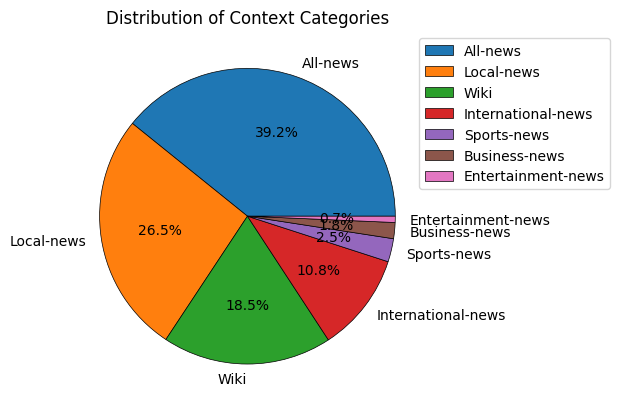

In [192]:
category_counts = df_final['category'].value_counts()
labels = category_counts.index.tolist()
plt.pie(category_counts, labels=labels, autopct='%1.1f%%', wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'} )
plt.title('Distribution of Context Categories')
plt.legend( loc = 'upper right', bbox_to_anchor=(1.5, 1))
plt.show()

In [193]:
category_counts = df_final['category'].value_counts()
print(f"Categories in 'category' variable: \n{category_counts}")

Categories in 'category' variable: 
category
All-news              6047
Local-news            4088
Wiki                  2857
International-news    1666
Sports-news            392
Business-news          271
Entertainment-news     105
Name: count, dtype: int64


### Pie chart to depict the Distribution of sites 

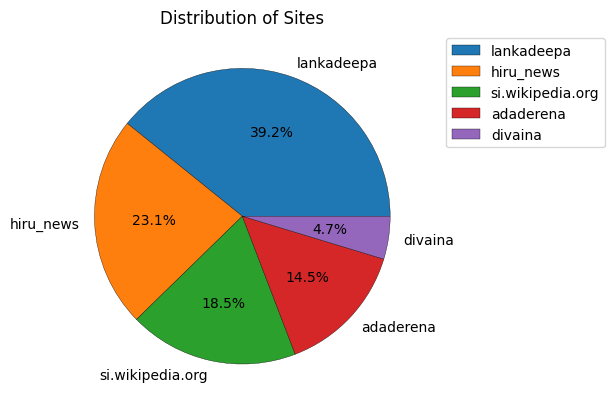

In [194]:
site_counts = df_final['site'].value_counts()
labels = site_counts.index.tolist()
plt.pie(site_counts, labels=labels, autopct='%1.1f%%', colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'], wedgeprops={'linewidth': 0.25, 'edgecolor': 'black'})
plt.title('Distribution of Sites')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()

In [195]:
site_counts = df_final['site'].value_counts()
print(f"Categories in 'site' variable: \n{site_counts}")

Categories in 'site' variable: 
site
lankadeepa          6047
hiru_news           3564
si.wikipedia.org    2857
adaderena           2235
divaina              723
Name: count, dtype: int64


### Group by 'site' and find the min, max, and mean length of 'context' for each site

In [196]:

site_length_stats = df_final.groupby('site')['context_length'].agg(['min', 'max', 'mean'])
print(site_length_stats)

                  min   max        mean
site                                   
adaderena         157  1737  695.112304
divaina           140  1604  427.666667
hiru_news         170  1815  622.564815
lankadeepa        140  1766  716.685629
si.wikipedia.org  120  1865  426.549177


### Histogram to depict the Distribution of character length of context

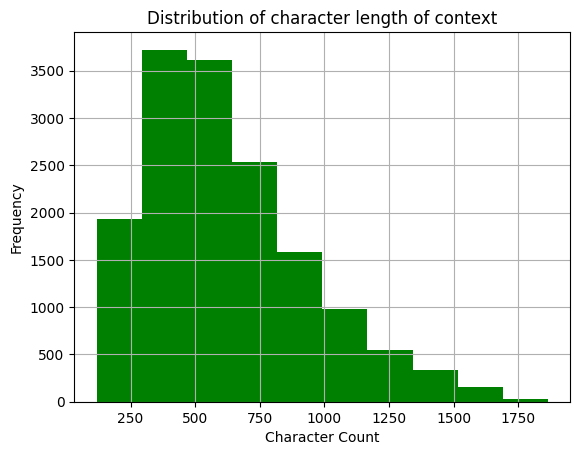

In [197]:
df_final['context'].str.len().hist(bins = 10, color = 'green')
plt.title('Distribution of character length of context')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()

In [198]:
print(f"Minimun number of characters in context: {df_final['context'].str.len().min()}")
print(f"Maximum number of character in context: {df_final['context'].str.len().max()}")

Minimun number of characters in context: 120
Maximum number of character in context: 1865


### Histogram to depict the Distribution of Word Count in Context

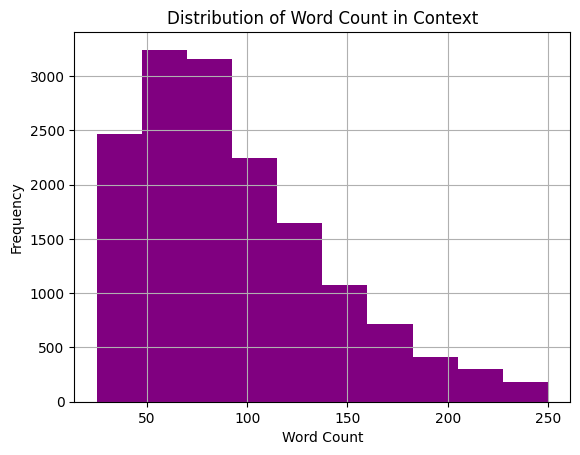

In [199]:
df_final['context'].str.split().map(lambda x: len(x)).hist(bins = 10, color = 'purple')
plt.title('Distribution of Word Count in Context')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [200]:
print(f"Minimun number of words in context: {df_final['context'].str.split().map(lambda x: len(x)).min()}")
print(f"Maximum number of words in context: {df_final['context'].str.split().map(lambda x: len(x)).max()}")

Minimun number of words in context: 25
Maximum number of words in context: 250


### Counts the occurence of stop words in content column

In [201]:
with open(STOP_WORDS_CORPUS_PATH, "r", encoding='utf-8') as word_list: # Path to stop words text file --- downloaded from https://github.com/nlpcuom/Sinhala-Stopword-list
    words = list(word_list.read().split('\n'))
    
stop = set(words)  # Adds the stop words to  SET to ommit the duplicate stop words

corpus=[]
new= df_final['context'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

### Histogram to depict the frequency of occurence of stop words

C:\Users\MSI\AppData\Local\Temp\ipykernel_22068\1495873239.py:9: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Sinhala.
  plt.tight_layout()
C:\Users\MSI\AppData\Local\Temp\ipykernel_22068\1495873239.py:9: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Sinhala.
  plt.tight_layout()


<BarContainer object of 20 artists>

d:\Desktop\FY\FYP\researchproject\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Sinhala.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Desktop\FY\FYP\researchproject\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Sinhala.
  fig.canvas.print_figure(bytes_io, **kw)


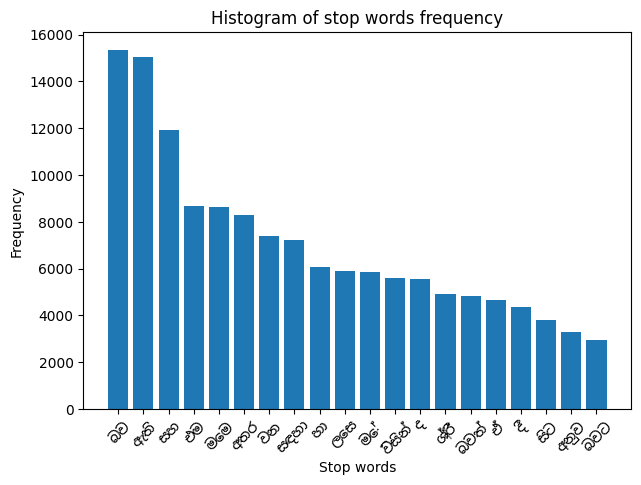

In [202]:
path = NOTOSANS_FONT_PATH # Path to sinhala font inorder to print the stop words in sinhala 
fontprop = fm.FontProperties(fname=path)
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:20] 
x,y=zip(*top)
plt.title('Histogram of stop words frequency')
plt.xlabel('Stop words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, fontproperties=fontprop)
plt.tight_layout() 
plt.bar(x,y,) 

### Top 10 Named Entity Recognition among randomly selected sample

In [ ]:

def plot_named_entity_barchart(text):
    # Load  Sinhala NER data from the partition.tsv file
    ner_data = pd.read_csv(NER_CORPUS_PATH, sep='\t',names=['entity', 'label'], header=None)  
    
    def _get_ner(text):
        entities = []
        for index, row in ner_data.iterrows():
            if row['entity'] in text and row['label'] != 'O': # Check if entity text is in the given text and avoid the entites without NER tags
                entities.append(row['entity'])  #
        return entities
    
    ent = text.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()
    
    x,y=map(list,zip(*counter.most_common(10)))
    sns.barplot(x=y, y=x)
    plt.title("Top 10 Named Entity Recognition")
    plt.yticks(rotation=45, fontproperties=fontprop)
    plt.xlabel("Count")
    plt.ylabel("Entities")
    plt.show()

d:\Desktop\FY\FYP\researchproject\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Sinhala.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Desktop\FY\FYP\researchproject\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Sinhala.
  fig.canvas.print_figure(bytes_io, **kw)


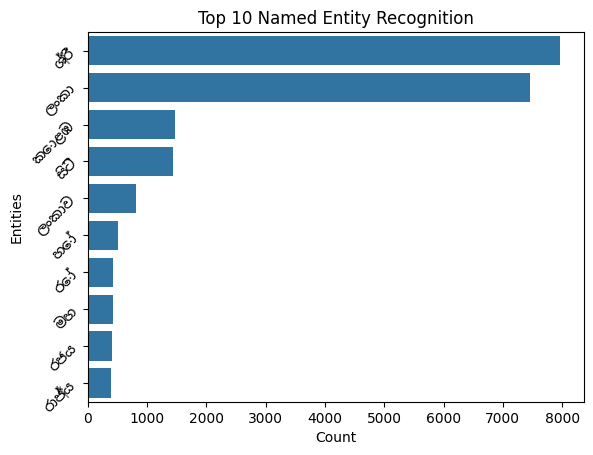

In [204]:
plot_named_entity_barchart(df_final['context'].sample(n=1000, random_state=1)) # Plots the Top 10 Named Entity Recognition for 1000 samples